# Prophet Forecasting

## Set up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from math import sqrt

In [2]:
# Plot aesthetics and settings
%matplotlib inline
plt.style.use('seaborn')


# plot function
def std_aesthetics(title='', x_label='', y_label='', h=8, w=16):
    # figure size
    plt.figure(figsize=(w,h))
    
    # Title and labels
    plt.title(title, fontsize=20)
    plt.xlabel(x_label, fontsize=16)
    plt.ylabel(y_label, fontsize=16)

    # Font sizes




In [3]:
# Importing the dataset
df = pd.read_csv('data/recruited_daily.csv')
df.head()

,date,Patients Recruited
0,2021-01-07,1
1,2021-01-10,2
2,2021-01-11,2
3,2021-01-12,9
4,2021-02-11,6


## Preprocessing

In [4]:
# Change dates to datetime objects
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date                  datetime64[ns]
Patients Recruited             int64
dtype: object

In [5]:
# Rename column names to 'ds' for the dates and 'y' for the values.
# This is for use with prophet
df.columns = ['ds', 'y']

df.head()

,ds,y
0,2021-01-07,1
1,2021-01-10,2
2,2021-01-11,2
3,2021-01-12,9
4,2021-02-11,6


In [6]:
# Creating a train-test split for cross validation
# Dates start at Jan 2021 and end Dec 2022 
cut_off_date = '2022-09-01'

# Splitting the dataset based on the above cut off date
train_df = df.loc[df['ds'] < cut_off_date]
test_df = df.loc[df['ds'] >= cut_off_date]

# Output some metrics about the split

train_df_len = train_df.shape[0]
test_df_len = test_df.shape[0]
print(f"length of train :{train_df_len} rows, length of test: {test_df_len} rows")
print(f"percentage of data = { round((train_df_len/df.shape[0]) *100)}% train / { round((test_df_len/df.shape[0]) *100)}% test")
print(f"number of months in test: { (test_df['ds'].max() - test_df['ds'].min()) /np.timedelta64(1, 'M') }")

length of train :260 rows, length of test: 25 rows
percentage of data = 91% train / 9% test
number of months in test: 3.186923756134623


In [7]:
# Create a new dataframe with resampled dates as monthly aggregates

# Function will take a dataframe in the format that prophet requires with columns titled 'ds' and 'y' for dates and values
# Function will return dataframe with monthly aggregated dates
def month_resample(data):
    resampled_data = data.set_index('ds').resample('M').sum()
    resampled_data = resampled_data.reset_index()
    
    return resampled_data

df_monthly = month_resample(df)
train_df_monthly = month_resample(train_df)
test_df_monthly = month_resample(test_df)

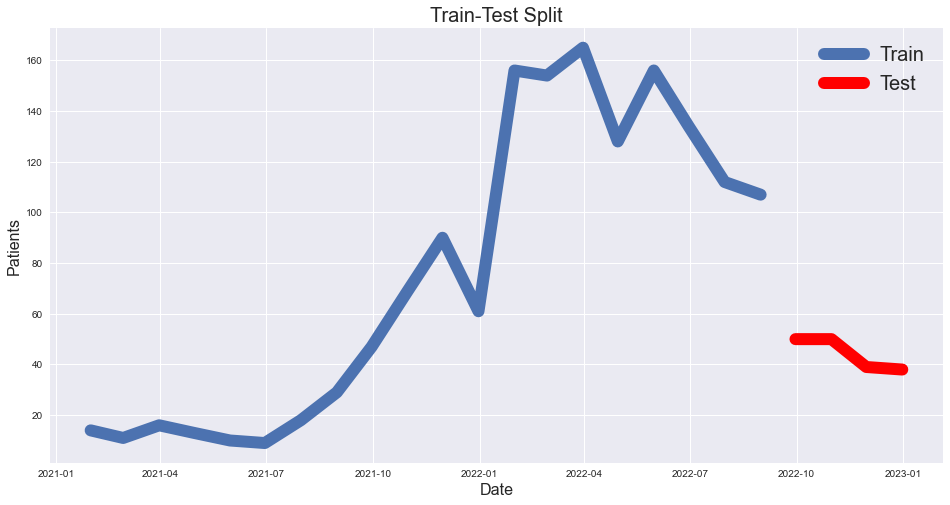

In [8]:
# Plot of the train-test split

# Plot aesthetics
std_aesthetics(title='Train-Test Split', x_label='Date', y_label='Patients')

# Plot of the train test split
plt.plot(train_df_monthly['ds'], train_df_monthly['y'], linewidth=12)
plt.plot(test_df_monthly['ds'], test_df_monthly['y'], linewidth=12, color='red')

# Legend
plt.legend(["Train", "Test"], fontsize=20)



plt.show()

## Forecasting (Performance Test)

16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:28 - cmdstanpy - INFO - Chain [1] done processing


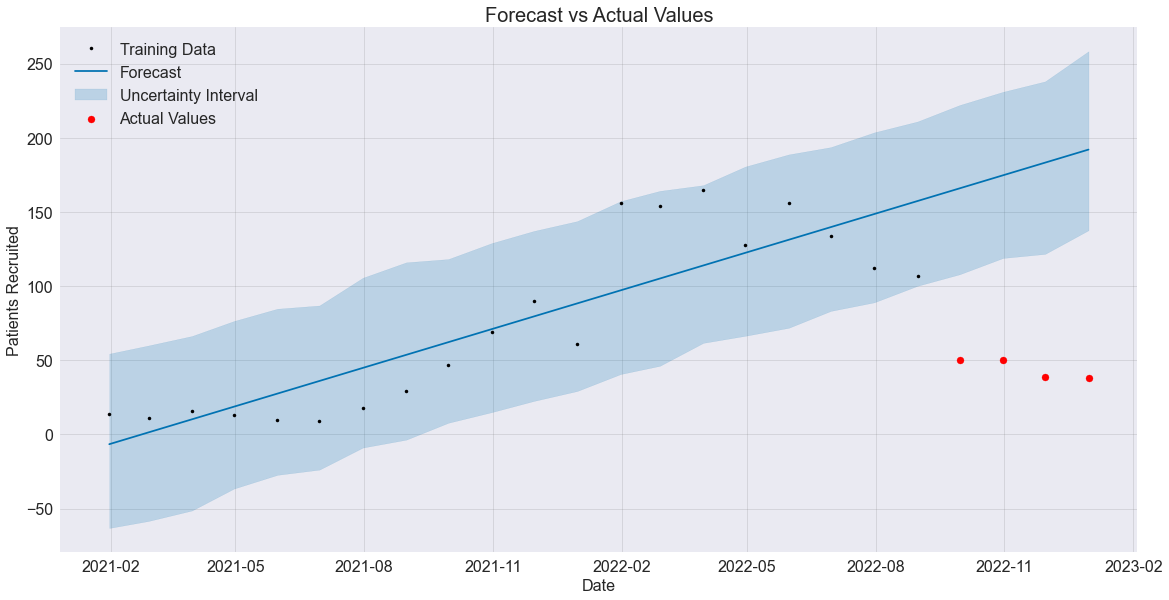

In [74]:
# Create an instance of an 'empty' model
m = Prophet(interval_width=0.95)

# Train the model
model = m.fit(train_df_monthly)

# Creating the future dates to forecast
future_dates = model.make_future_dataframe(periods=4, freq='M')

# Forecasting output
forecast = model.predict(future_dates)

# Plot the forecast 
fig = model.plot(forecast, xlabel='Date', ylabel='Patients Recruited', figsize=(16,8))

# Add aesthitic changes
ax = fig.gca()
ax.set_title("Forecast vs Actual Values", size=20)
ax.set_xlabel("Date", size=16)
ax.set_ylabel("Patients Recruited", size=16)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

# Plot the actual values
actual_vals = plt.scatter(test_df_monthly['ds'], test_df_monthly['y'], facecolor='red')


# Legend
plt.legend(['Training Data', 'Forecast', 'Uncertainty Interval', 'Actual Values'], 
           loc=2, 
           fontsize=16)

plt.show()

In [119]:
# Calculating Performance Metrics

# Lists of predicted values and actual values
y_hat = forecast['yhat'][-4:]
actual = test_df_monthly['y']

# RMSE
mse = mean_squared_error(y_true=actual, y_pred=y_hat)
rmse = sqrt(mse) # this is the average amount the model is off by, returned in the same units of measure as the dependent variable

# MAPE
mape = mean_absolute_percentage_error(y_true=actual, y_pred=y_hat) # a value between 0-1 equates to 0%-100%

print(f'The model\'s RMSE: {np.round(rmse, 2)} patients \n  The Model\'s MAPE: {np.round(mape*100, 2)}%')

The model's RMSE: 135.58 patients 
  The Model's MAPE: 314.14%


In [181]:
# Table of performance metrics
mape_str = str(np.round(mape*100, 2)) + '%'
rmse_str = str(np.round(rmse, 2)) + ' patients'

performance_df = pd.DataFrame({'RMSE':[rmse_str], 'MAPE': [mape_str]})

performance_df

,RMSE,MAPE
0,135.58 patients,314.14%


## Forecasting (Predictions)

17:03:54 - cmdstanpy - INFO - Chain [1] start processing
17:03:54 - cmdstanpy - INFO - Chain [1] done processing


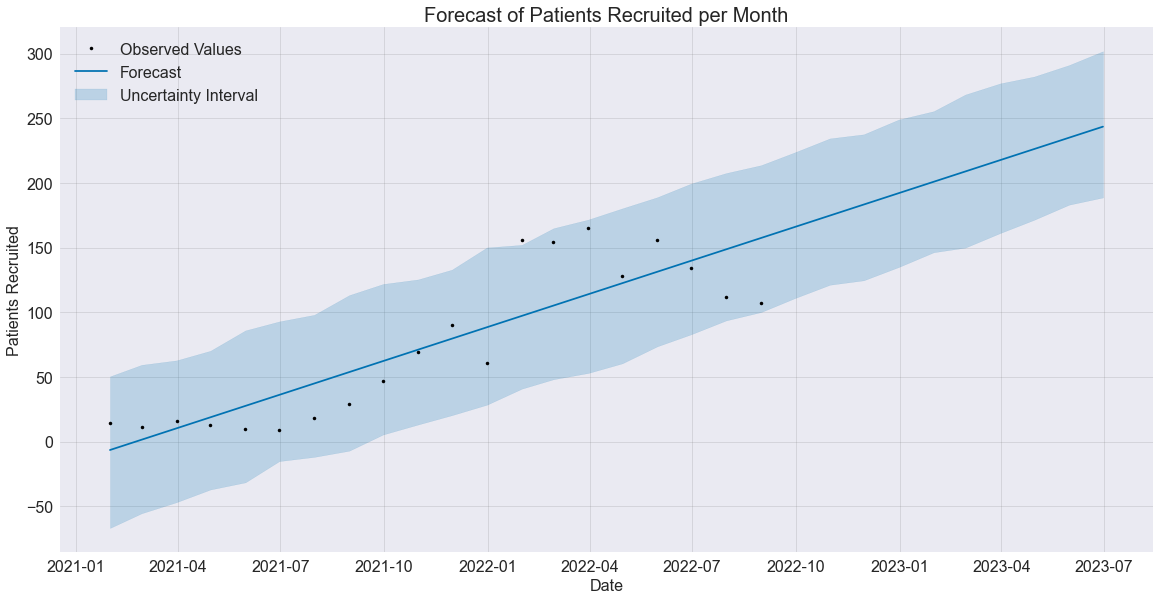

In [127]:
# Create an instance of an 'empty' model
m = Prophet(interval_width=0.95)

# Train the model
final_model = m.fit(df_monthly)

# Creating the future dates to forecast
final_future_dates = final_model.make_future_dataframe(periods=6, freq='M')
final_future_dates

# Forecasting output
final_forecast = model.predict(final_future_dates)

# Plot the forecast
fig = model.plot(final_forecast, xlabel='Date', ylabel='Patients Recruited', figsize=(16,8))

# Add aesthitic changes
ax = fig.gca()
ax.set_title("Forecast of Patients Recruited per Month", size=20)
ax.set_xlabel("Date", size=16)
ax.set_ylabel("Patients Recruited", size=16)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=16)

# Legend
plt.legend(['Observed Values', 'Forecast', 'Uncertainty Interval'], 
           loc=2, 
           fontsize=16)



plt.show()

In [166]:
# A dataframe of the model's predictions for the following six months
forecast_df = pd.DataFrame(final_forecast[['ds', 'yhat']][-6:])

# Renaming columns
forecast_df = forecast_df.rename(columns={'ds':'Month', 'yhat':'Patients Recruited'})

# Reformating dates as 'Month Year'
forecast_df['Month'] = [x.strftime('%b %Y') for x in forecast_df['Month']]

# Setting the date column as the table's index
forecast_df = forecast_df.set_index('Month')

# rounding the values
forecast_df['Patients Recruited'] = np.round(forecast_df['Patients Recruited'])

forecast_df

,Patients Recruited
Month,
Jan 2023,201.0
Feb 2023,209.0
Mar 2023,218.0
Apr 2023,226.0
May 2023,235.0
Jun 2023,243.0


## Notes, Challenges and Future Improvements

There has been terrible model performance. <br>
- What are the predictions and what are their measures of reliability?

<br>
Why has this been the case? <br>
- lack of data. There are only 2 years worth of data and we would like to know what will happen half a year to one year in the future.
- Both years in the data are completely different.
- Is there any seasonality to be seen in the data? I'm not sure that there is. If not then only the trend has anything useful to show.

<br>
What would the next steps look like
- Is there an issue with the data that can be fixed? Maybe a mention of just collecting more data? Would bootsrapping help?
- Would a different model be more useful? XGBoost for example?

I've made a mistake in confusing forecasting with modelling in this project. I do not need a train-test split becuase I am not building a ML model and subsequently do not need to understand how it might perform with data outside of the training data. I am not building a model that will generalise predictions to unforseen data, instead I am taking the data I have and predicting what the value will be in the future. Predictive analysis can be done with forecasting as well as modelling. More generally, you can probably forecast with modelling but forecasting is not the same thing as modelling.

Some notes about what Prophet is doing: <br>
You'll note that I've made no attempt at making the data stationary before shoving it into a model, but apparently the model that prophet is using isn't concerned with stationarity... <br>
*"No. Stationarity is an important condition for some other time series forecasting algorithms such as ARMA or ARIMA, but prophet assumes nothing about stationarity. Prophet rather makes use of features like trend or seasonality, which stationary data by definition do not have"*
<br><br>
I'll probably want to learn how to intepret the plot and dataframe that prophet has output above, next.
...